In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [12]:
import pandas as pd

# Load the dataset
df = pd.read_csv('post natal data.csv')

# Drop the 'Timestamp' column if it exists
if 'Timestamp' in df.columns:
    df.drop('Timestamp', axis=1, inplace=True)

# Fill missing values with 'Maybe'
df.fillna('Maybe', inplace=True)

# Strip whitespace and convert all string values to lowercase
df = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

# Define the mapping for categorical values
mapping = {
    'yes': 1, 
    'no': 0, 
    'maybe': 0.5, 
    'sometimes': 0.5, 
    'two or more days a week': 1  
}

# Apply the mapping to all columns
for col in df.columns:
    df[col] = df[col].map(mapping).fillna(0)

# Define the age mapping
age_mapping = {'18-25': 1, '25-30': 2, '30-35': 3, '35-40': 4, '40-45': 5}

# Apply the age mapping if 'age' column exists
if 'age' in df.columns:
    df['age'] = df['age'].map(age_mapping).fillna(0)  # Fixed the typo here

C:\Users\user\AppData\Local\Temp\ipykernel_19236\768256932.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)


In [46]:
# Verify unique values
print(df['Trouble sleeping at night'].unique())

[1. 0.]


In [13]:
print('Mean Sleep Issues:', df['Trouble sleeping at night'].mean())
print('Median Sleep Issues:', df['Trouble sleeping at night'].median())
print('Mode Sleep Issues:', df['Trouble sleeping at night'].mode()[0])  # mode() returns a Series, so we take the first value
print('Variance of Sleep Issues:', df['Trouble sleeping at night'].var())
print('Standard Deviation of Sleep Issues:', df['Trouble sleeping at night'].std())

Mean Sleep Issues: 0.7218895542248835
Median Sleep Issues: 1.0
Mode Sleep Issues: 1.0
Variance of Sleep Issues: 0.20089869085619366
Standard Deviation of Sleep Issues: 0.4482172362328268


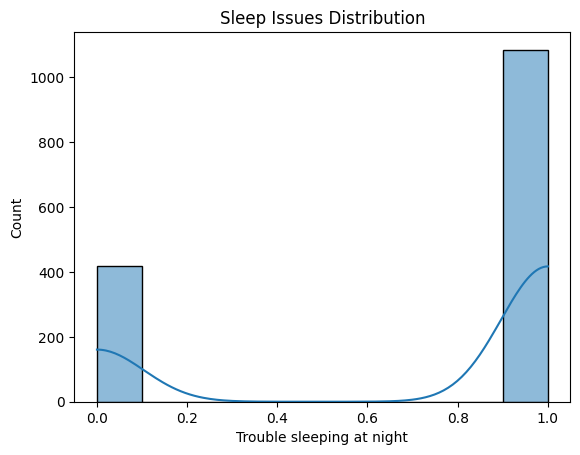

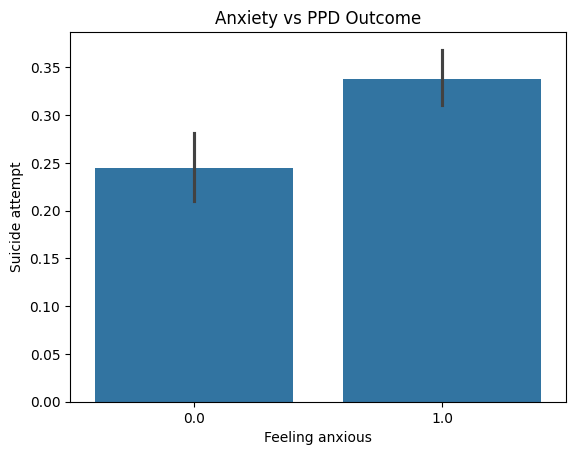

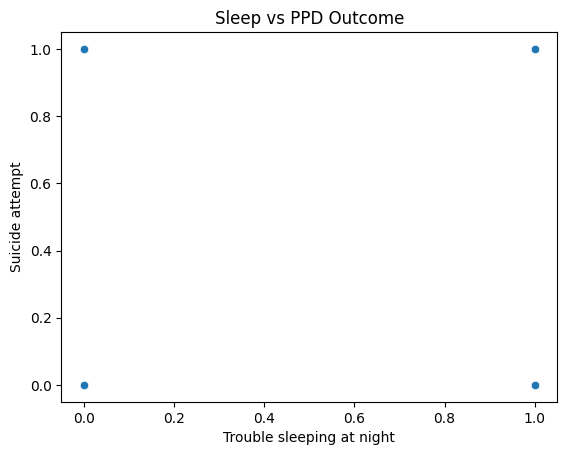

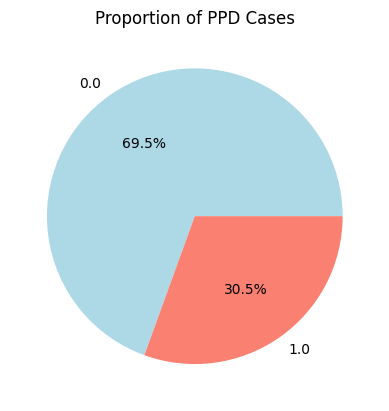

In [14]:
sns.histplot(df['Trouble sleeping at night'], bins=10, kde=True)
plt.title('Sleep Issues Distribution')
plt.show()
sns.barplot(x='Feeling anxious', y='Suicide attempt', data=df)
plt.title('Anxiety vs PPD Outcome')
plt.show()
sns.scatterplot(x='Trouble sleeping at night', y='Suicide attempt', data=df)
plt.title('Sleep vs PPD Outcome')
plt.show()
ppd_counts = df['Suicide attempt'].value_counts()
plt.pie(ppd_counts, labels=ppd_counts.index, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Proportion of PPD Cases')
plt.show()

In [15]:
ppd_probability = df['Suicide attempt'].mean()
print(f"Probabiity of PPD:{ppd_probability:.2f}")

Probabiity of PPD:0.31


In [16]:
correlation = df['Trouble sleeping at night'].corr(df['Suicide attempt'])
print(f'correlation between suicide attempt and PPD:{correlation}')

correlation between suicide attempt and PPD:0.1342896310653514


In [17]:
mean = df['Trouble sleeping at night'].mean()
std = df['Trouble sleeping at night'].std()
n = len(df['Trouble sleeping at night'])
confidence_interval=stats.norm.interval(0.95,loc=mean,scale=std/np.sqrt(n))
print(f"confidence interval is {confidence_interval}")

confidence interval is (0.6992296977855931, 0.744549410664174)


In [58]:
# Probability of PPD
P_A = df['Suicide attempt'].mean()

# Probability of Sleep < 5 AND Anxiety == 1 (Joint Probability)
P_B = ((df['Trouble sleeping at night'] < 5) & (df['Feeling anxious'] == 1)).mean()

# Probability of Sleep < 5 AND Anxiety == 1 GIVEN PPD (Conditional Probability)
if df['Suicide attempt'].sum() > 0:  # Check to avoid division by zero
    P_B_given_A = ((df.loc[df['Suicide attempt'] == 1, 'Trouble sleeping at night'] < 5) & 
                   (df.loc[df['Suicide attempt'] == 1, 'Feeling anxious'] == 1)).mean()
else:
    P_B_given_A = 0  # Handle case where no PPD cases exist

# Apply Bayes' Theorem
if P_B > 0:
    P_A_given_B = (P_B_given_A * P_A) / P_B
    print(f"Probability of PPD given Sleep < 5 + Anxiety (Bayes): {P_A_given_B:.2f}")
else:
    print("No matching cases found for Sleep < 5 + Anxiety.")

Probability of PPD given Sleep < 5 + Anxiety (Bayes): 0.34


In [59]:
from scipy import stats

# Filter data for PPD and non-PPD groups
ppd = df[df['Suicide attempt'] == 1]['Trouble sleeping at night'].dropna()  # Drop missing values
non_ppd = df[df['Suicide attempt'] == 0]['Trouble sleeping at night'].dropna()  # Drop missing values

# Check group sizes
print(f"PPD group size: {len(ppd)}")
print(f"Non-PPD group size: {len(non_ppd)}")

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(ppd, non_ppd, equal_var=False)  # Assume unequal variances
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}")

PPD group size: 459
Non-PPD group size: 1044
T-statistic: 5.62, P-value: 0.000


In [61]:
# Probability that mother has sleep trouble + anxiety when PPD exists
P_B_given_A = df.loc[
    (df['Suicide attempt'] == 1) & 
    (df['Trouble sleeping at night'] == 1) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.loc[df['Suicide attempt'] == 1].shape[0]

# Probability of sleep trouble + anxiety existing generally
P_B = df.loc[
    (df['Trouble sleeping at night'] == 1) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.shape[0]

# Probability of PPD cases
P_A = df['Suicide attempt'].mean()

def predict_ppd(sleep, anxiety):
    """
    Predicts the risk level of PPD based on sleep trouble and anxiety.
    
    Parameters:
        sleep (int): 1 if sleep trouble exists, 0 otherwise.
        anxiety (int): 1 if anxiety exists, 0 otherwise.
    
    Returns:
        str: Risk level ("High Risk", "Moderate Risk", or "Low Risk").
    """
    if sleep == 1 and anxiety == 1:
        if P_B > 0:
            prob = (P_B_given_A * P_A) / P_B
        else:
            prob = 0
    else:
        prob = 0  # If conditions are not met, assume low risk
    
    print(f"P(A) = {P_A:.2f}, P(B) = {P_B:.2f}, P(B|A) = {P_B_given_A:.2f}, P(A|B) = {prob:.2f}")
    
    if prob > 0.7:
        return "High Risk"
    elif prob > 0.4:
        return "Moderate Risk"
    else:
        return "Low Risk"

# Test
print(predict_ppd(1, 1))  # Example: Mother has sleep trouble and anxiety

P(A) = 0.31, P(B) = 0.43, P(B|A) = 0.62, P(A|B) = 0.44
Moderate Risk


In [50]:
# Probability of PPD cases
P_A = df['Suicide attempt'].mean()

# Probability that a mother has sleep trouble + anxiety when PPD exists
P_B_given_A = df.loc[
    (df['Suicide attempt'] == 1) &
    (df['Trouble sleeping at night'] >= 0.5) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.loc[df['Suicide attempt'] == 1].shape[0]

# Probability that a mother generally has sleep trouble + anxiety
P_B = df.loc[
    (df['Trouble sleeping at night'] >= 0.5) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.shape[0]

def predict_ppd(sleep, anxiety):
    # Map sleep to binary values
    sleep = 1 if sleep >= 0.5 else 0
    anxiety = 1 if anxiety == 1 else 0
    
    if P_B > 0:
        prob = (P_B_given_A * P_A) / P_B
    else:
        prob = 0
    
    print(f"P(A) = {P_A:.2f}, P(B) = {P_B:.2f}, P(B|A) = {P_B_given_A:.2f}, P(A|B) = {prob:.2f}")
    
    if prob > 0.7:
        return "High Risk"
    elif prob > 0.4:
        return "Moderate Risk"
    else:
        return "Low Risk"

# Test Case — Should now give HIGH RISK
print(predict_ppd(0, 0))  # Sleep + Anxiety = Yes


P(A) = 0.31, P(B) = 0.43, P(B|A) = 0.62, P(A|B) = 0.44
Moderate Risk


In [54]:
# Probability that mother has sleep trouble + anxiety when PPD exists
P_B_given_A = df.loc[
    (df['Suicide attempt'] == 1) &
    (df['Trouble sleeping at night'] == 1) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.loc[df['Suicide attempt'] == 1].shape[0]

# Probability of sleep trouble + anxiety existing generally
P_B = df.loc[
    (df['Trouble sleeping at night'] == 1) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.shape[0]

# Probability of PPD cases
P_A = df['Suicide attempt'].mean()

print(f"P(A) = {P_A:.2f}, P(B) = {P_B:.2f}, P(B|A) = {P_B_given_A:.2f}")


P(A) = 0.31, P(B) = 0.43, P(B|A) = 0.62


In [56]:
# Probability of PPD cases (P(A))
P_A = df['Suicide attempt'].mean()

# Probability of sleep + anxiety existing (P(B))
P_B = df.loc[
    (df['Trouble sleeping at night'] == 1) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.shape[0]

# Probability of sleep + anxiety when PPD exists (P(B|A))
P_B_given_A = df.loc[
    (df['Suicide attempt'] == 1) &
    (df['Trouble sleeping at night'] == 1) & 
    (df['Feeling anxious'] == 1)
].shape[0] / df.loc[df['Suicide attempt'] == 1].shape[0]

# Final Probability of PPD given Sleep Trouble + Anxiety (Bayes Theorem)
if P_B > 0:
    P_A_given_B = (P_B_given_A * P_A) / P_B
else:
    P_A_given_B = 0

print(f"P(A) = {P_A:.2f}, P(B) = {P_B:.2f}, P(B|A) = {P_B_given_A:.2f}, P(A|B) = {P_A_given_B:.2f}")


P(A) = 0.31, P(B) = 0.43, P(B|A) = 0.62, P(A|B) = 0.44


In [57]:
def predict_ppd(sleep, anxiety):
    if sleep == 1 and anxiety == 1:  # Only count cases where both sleep & anxiety are present
        prob = (P_B_given_A * P_A) / P_B
    else:
        prob = 0
    
    print(f"P(A) = {P_A:.2f}, P(B) = {P_B:.2f}, P(B|A) = {P_B_given_A:.2f}, P(A|B) = {prob:.2f}")
    
    if prob > 0.7:
        return "High Risk"
    elif prob > 0.4:
        return "Moderate Risk"
    else:
        return "Low Risk"

# Test Case — This should now give High Risk if sleep + anxiety values are high
print(predict_ppd(1, 1))


P(A) = 0.31, P(B) = 0.43, P(B|A) = 0.62, P(A|B) = 0.44
Moderate Risk
